## 8. 도로 영역을 찾자! - 세그멘테이션 모델 만들기

### [ 목 차 ]
1. 데이터 불러오기
2. U-Net 모델 구현
3. U-Net++ 모델 구현
4. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석
5. 결론     


[ 회 고 ]

### 1. 데이터 불러오기
KITTI 데이터셋 수집과 구축

In [ ]:
# 필요한 라이브러리를 로드합니다. 
import os
import math
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import plot_model

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

from albumentations import HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

print('슝=3')

슝=3


In [ ]:
# data path
DATA_DIR = '/content/drive/MyDrive/going_deeper/sementic_segmentation/data'

TRAIN_PATH = os.path.join(DATA_DIR, 'training')
TEST_PATH = os.path.join(DATA_DIR, 'testing')

In [ ]:
# albumentations를 이용한 augmentation 함수 구성

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

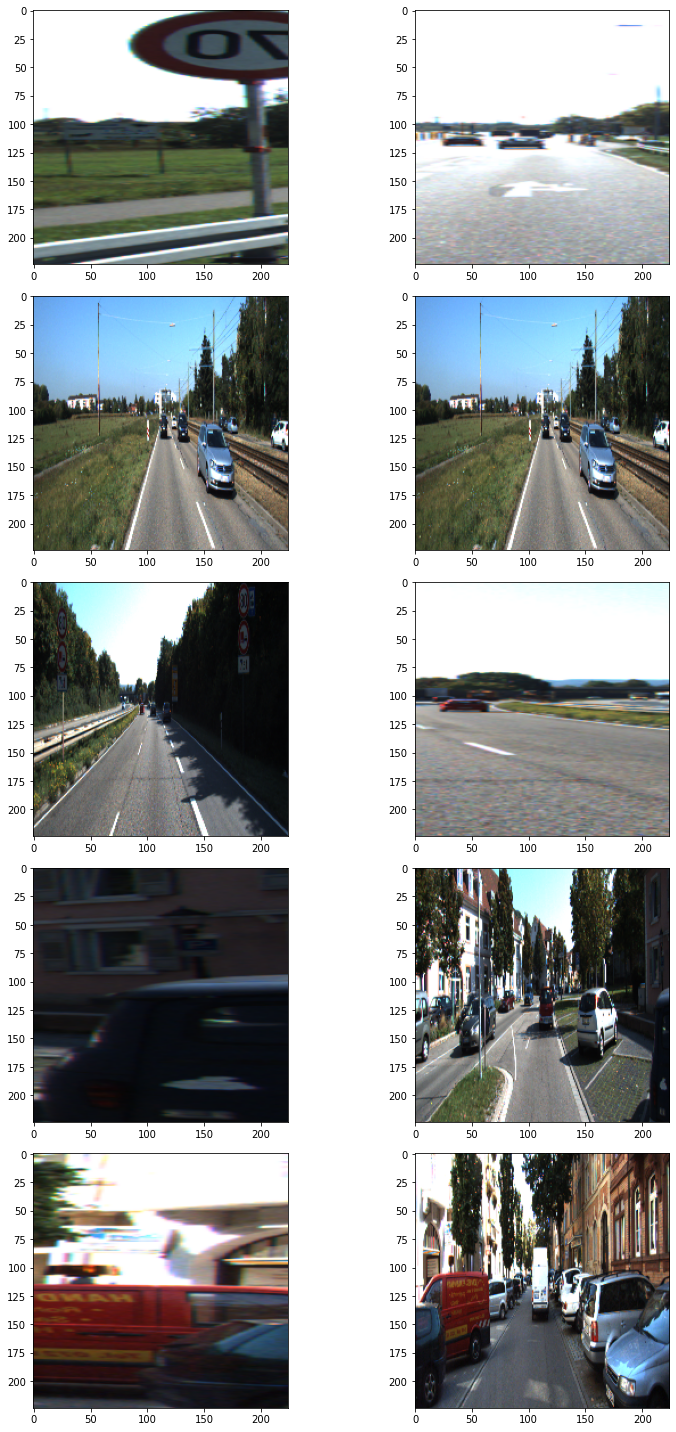

In [ ]:
# 훈련데이터 샘플 및 augmentation 적용
augmentation = build_augmentation()

input_images = glob(os.path.join(TRAIN_PATH, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  

plt.tight_layout()
plt.show() 

In [ ]:
# tf.keras.utils.Sequence를 상속받은 generator 형태로 데이터를 구성

class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
              train_path,
              batch_size=16,
              img_size=(224, 224, 3),
              output_size=(224, 224),
              is_train=True,
              augmentation=None):
    '''
    TRAIN_PATH: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.TRAIN_PATH = train_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.TRAIN_PATH, "image_2", "*.png"))
    label_images = glob(os.path.join(self.TRAIN_PATH, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                          index*self.batch_size:
                          (index + 1)*self.batch_size
                          ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [ ]:
BATCH_SIZE = 8

# augmentation = build_augmentation()
train_preproc = build_augmentation(is_train=True)
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    TRAIN_PATH,
    BATCH_SIZE,
    augmentation=train_preproc,
    is_train=True
)

test_generator = KittiGenerator(
    TRAIN_PATH,
    BATCH_SIZE, 
    augmentation=test_preproc,
    is_train=False
)

### 2. U-Net 모델 구현
  * U-Net 및 U-Net++ 모델 구성은 https://github.com/CarryHJR/Nested-UNet/blob/master/model.py 참조
  * 참조 모델에서 activation 함수로 elu를 사용했으나, 여기서는 Node처럼 relu함수를 사용

[ U-Net모델 ]     
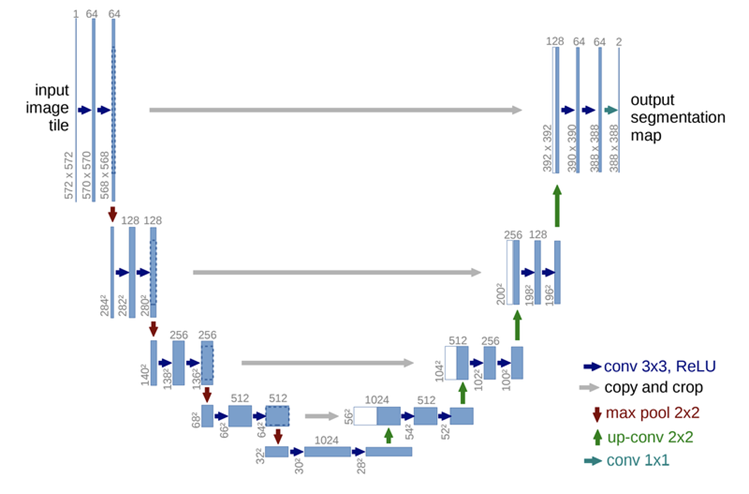 

In [ ]:
def conv_block(dim, x, concat_list=[], to_up_concat=False, to_pool=False):
    if to_up_concat:
        x = Conv2DTranspose(dim, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(x)  # Up Sampling
        concat_list.append(x)
        x = concatenate(concat_list, axis = 3)  # Skip Connection

    x = Conv2D(dim, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)  # x = Dropout(0.5)(x)
    x = Conv2D(dim, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)  # x = Dropout(0.5)(x)

    if to_pool:
        x = MaxPooling2D(pool_size=(2, 2))(x)  # Down Sampling

    return x

def get_model_outputs(x):
    x = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x)     
    x = Conv2D(1, 1, activation='sigmoid')(x)

    return x

In [ ]:
def build_unet(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    filter_list = [64,128,256,512,1024]

    # Contracting Path (Left)
    conv1 = conv_block(filter_list[0], inputs)
    conv2 = conv_block(filter_list[1], conv1, to_pool=True)
    conv3 = conv_block(filter_list[2], conv2, to_pool=True)
    conv4 = conv_block(filter_list[3], conv3, to_pool=True)

    conv5 = conv_block(filter_list[4], conv4, to_pool=True)  # (Middle)

    # Expanding Path (Right)
    conv6 = conv_block(filter_list[3], conv5, [conv4], to_up_concat=True)
    conv7 = conv_block(filter_list[2], conv6, [conv3], to_up_concat=True)
    conv8 = conv_block(filter_list[1], conv7, [conv2], to_up_concat=True)
    conv9 = conv_block(filter_list[0], conv8, [conv1], to_up_concat=True)

    outputs = get_model_outputs(conv9)

    # U-Net 생성
    model = Model(inputs = inputs, outputs = outputs)
    return model

In [ ]:
# 모델 생성
unet = build_unet()

In [ ]:
# 모델 구조
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

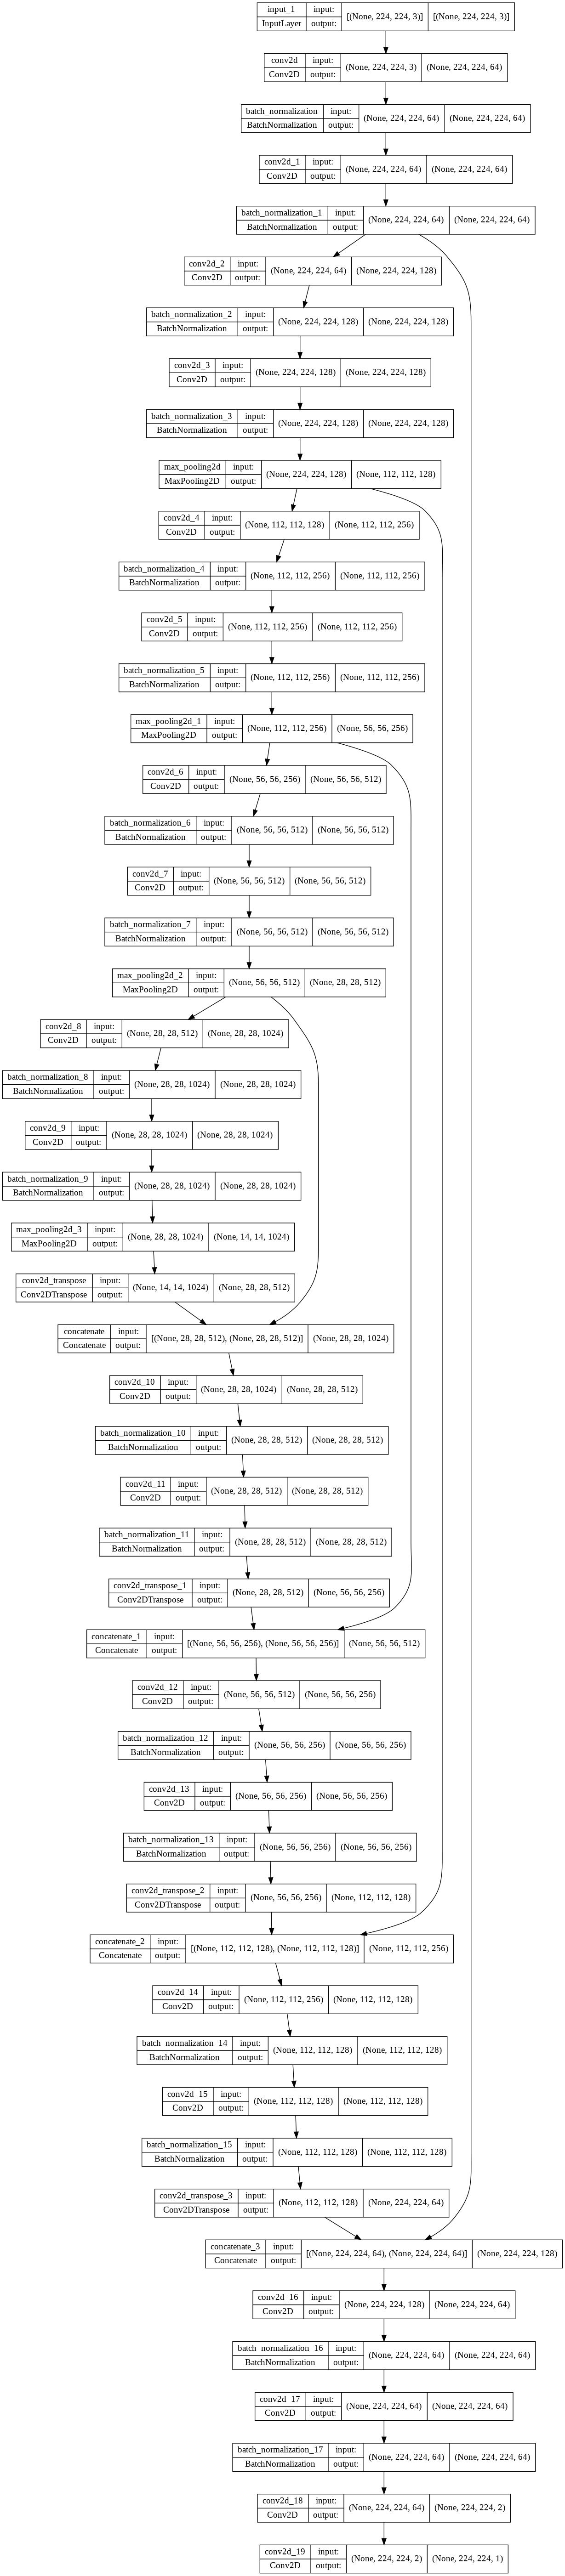

In [ ]:
# 모델 구조 시각화
plot_model(unet, to_file=os.path.join(DATA_DIR, f'U-Net_shapes.png'), show_shapes=True)

In [ ]:
# 모델 학습

EPOCHS = 100

unet.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy', metrics=['accuracy'])
unet_history = unet.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
)

Epoch 1/100
22/22 [==============================] - 28s 569ms/step - loss: 1.0913 - accuracy: 0.3513 - val_loss: 0.6987 - val_accuracy: 0.9430
Epoch 2/100
22/22 [==============================] - 7s 329ms/step - loss: 0.8501 - accuracy: 0.3367 - val_loss: 0.6920 - val_accuracy: 0.9506
Epoch 3/100
22/22 [==============================] - 7s 329ms/step - loss: 0.7907 - accuracy: 0.3602 - val_loss: 0.6904 - val_accuracy: 0.9540
Epoch 4/100
22/22 [==============================] - 7s 328ms/step - loss: 0.7522 - accuracy: 0.5480 - val_loss: 0.6894 - val_accuracy: 0.9554
Epoch 5/100
22/22 [==============================] - 7s 329ms/step - loss: 0.7309 - accuracy: 0.6667 - val_loss: 0.6881 - val_accuracy: 0.9618
Epoch 6/100
22/22 [==============================] - 7s 329ms/step - loss: 0.7186 - accuracy: 0.6924 - val_loss: 0.6872 - val_accuracy: 0.9622
Epoch 7/100
22/22 [==============================] - 7s 329ms/step - loss: 0.7059 - accuracy: 0.7827 - val_loss: 0.6862 - val_accuracy: 0.965

In [ ]:
# 학습 결과 시각화
def draw_unet_history(history, model_name='U-Net'):
    plt.subplots(figsize=(12,4))

    # Model Loss, Validation Loss 시각화
    plt.subplot(121)
    plt.plot(history.history['loss'], 'r')
    plt.plot(history.history['val_loss'], 'b')
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')

    # Model Accuracy, Validation Accuracy 시각화
    plt.subplot(122)
    plt.plot(history.history['accuracy'], 'r')
    plt.plot(history.history['val_accuracy'], 'b')
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')

    plt.tight_layout()
    plt.show()

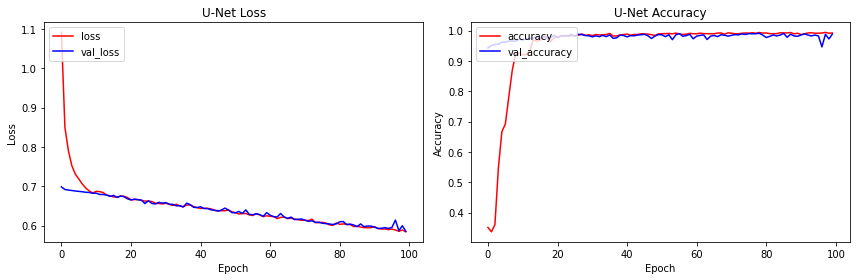

In [ ]:
draw_unet_history(unet_history, 'U-Net')

In [ ]:
# 모델 저장
UNET_PATH = os.path.join(DATA_DIR, 'seg_model_unet.h5')
unet.save(UNET_PATH)  # 학습한 모델을 저장해 주세요.

### 3. U-Net++ 모델 구현

[ U-Net++ 모델 ]    
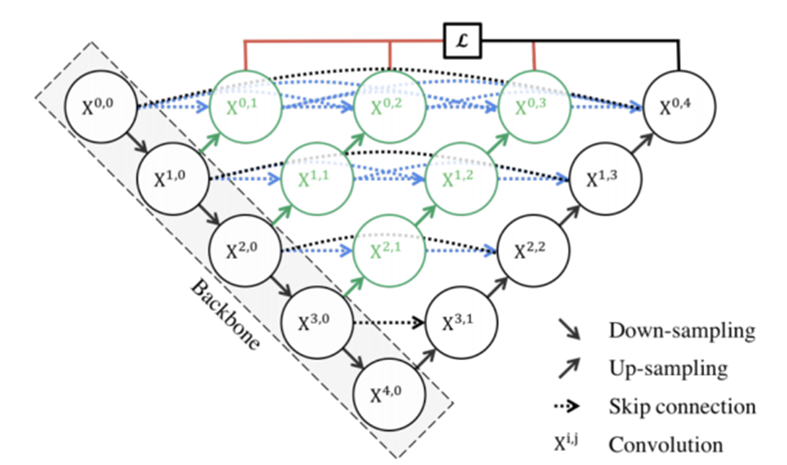

In [ ]:
def build_unet_pp(input_shape=(224, 224, 3), deep_supervision=True):
    inputs = Input(input_shape)

    filter_list = [64,128,256,512,1024]

    x_00 = conv_block(filter_list[0], inputs)
    x_10 = conv_block(filter_list[1], x_00, to_pool=True)
    x_20 = conv_block(filter_list[2], x_10, to_pool=True)
    x_30 = conv_block(filter_list[3], x_20, to_pool=True)
    x_40 = conv_block(filter_list[4], x_30, to_pool=True)

    x_01 = conv_block(filter_list[0], x_10, [x_00], to_up_concat=True)
    x_11 = conv_block(filter_list[1], x_20, [x_10], to_up_concat=True)
    x_21 = conv_block(filter_list[2], x_30, [x_20], to_up_concat=True)

    x_02 = conv_block(filter_list[0], x_11, [x_00,x_01], to_up_concat=True)
    x_12 = conv_block(filter_list[1], x_21, [x_10,x_11], to_up_concat=True)

    x_03 = conv_block(filter_list[0], x_12, [x_00,x_01,x_02], to_up_concat=True)

    x_31 = conv_block(filter_list[3], x_40, [x_30], to_up_concat=True)
    x_22 = conv_block(filter_list[2], x_31, [x_20], to_up_concat=True)
    x_13 = conv_block(filter_list[1], x_22, [x_10], to_up_concat=True)
    x_04 = conv_block(filter_list[0], x_13, [x_00,x_01,x_02,x_03], to_up_concat=True)

    if deep_supervision:
        x_01_outputs = get_model_outputs(x_01)
        x_02_outputs = get_model_outputs(x_02)
        x_03_outputs = get_model_outputs(x_03)
        x_04_outputs = get_model_outputs(x_04)

        outputs_list = [x_01_outputs, x_02_outputs, x_03_outputs, x_04_outputs]
        outputs = tf.keras.layers.Average()(outputs_list)  # 레이어 모든 값 평균 계산 => sum(outputs_list)/len(outputs_list) 과 결과 같음
    else:
        outputs = get_model_outputs(x_04)

    # U-Net++ 생성
    model = Model(inputs = inputs, outputs = outputs)
    return model

In [ ]:
# 모델 생성
unet_pp = build_unet_pp()

In [ ]:
# 모델 구조
unet_pp.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 224, 224, 64  256        ['conv2d_20[0][0]']              
 ormalization)                  )                                                           

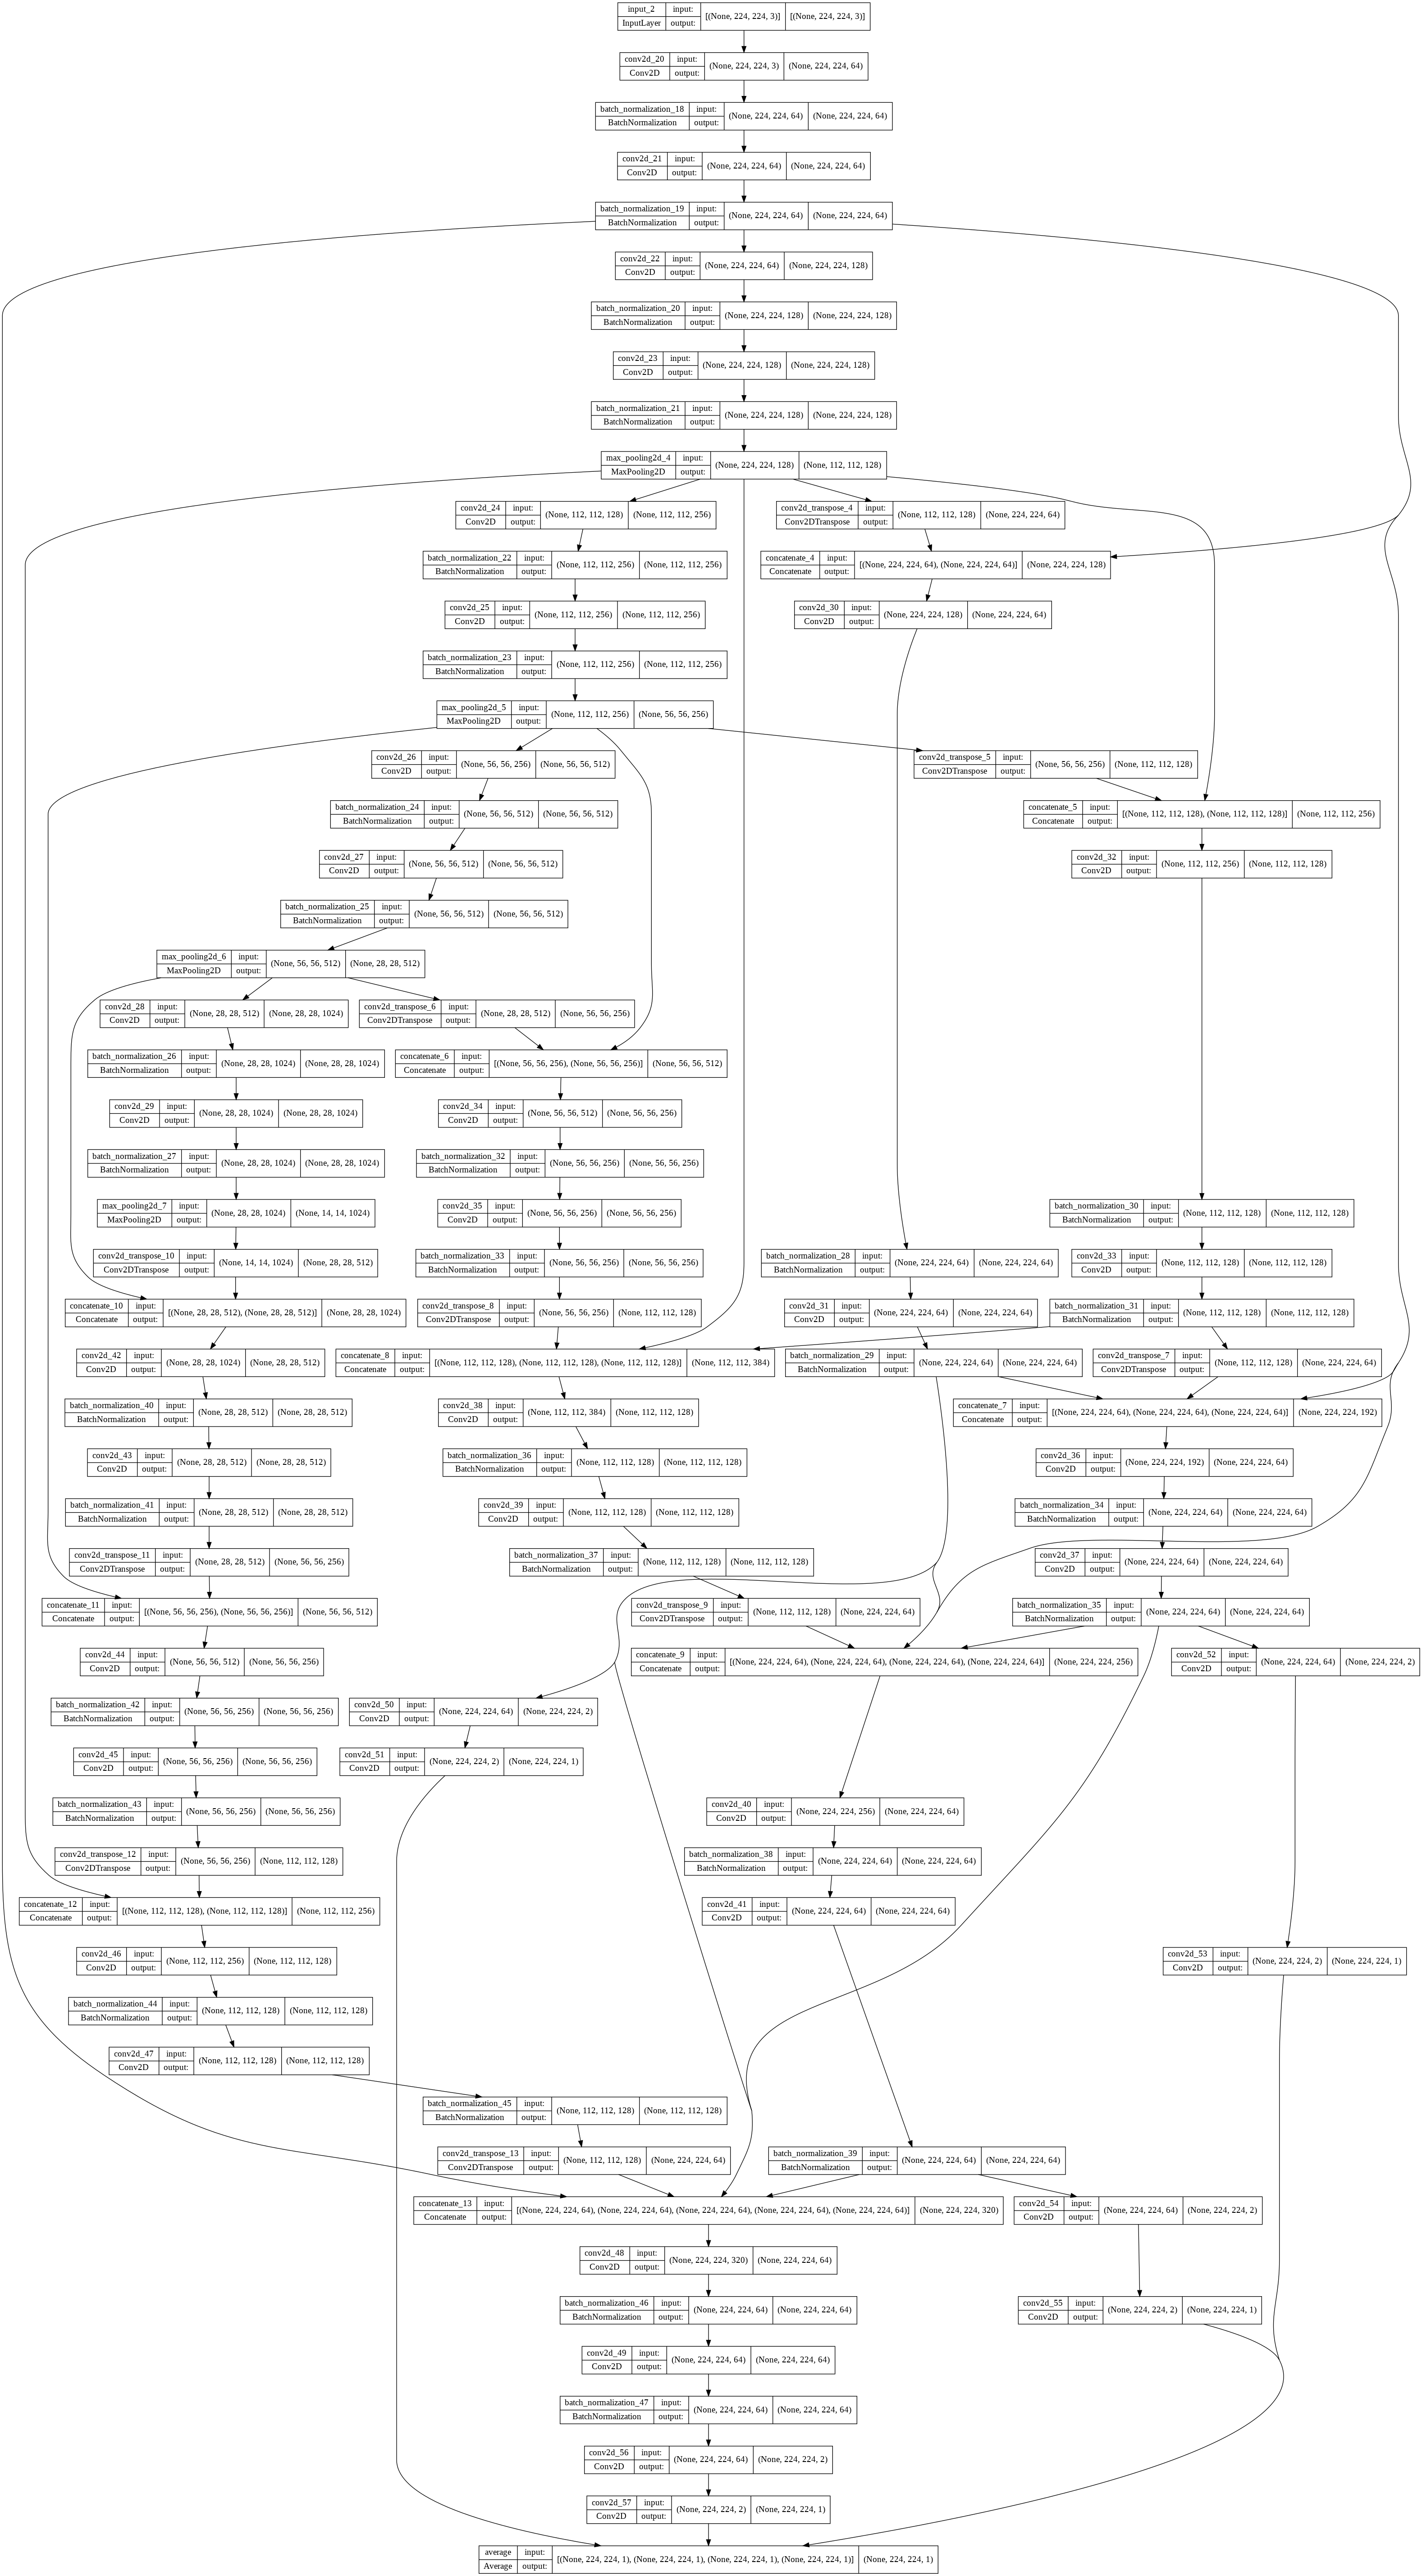

In [ ]:
# 모델 구조 시각화
plot_model(unet_pp, to_file=os.path.join(DATA_DIR, f'U-Net++_shapes.png'), show_shapes=True)

In [ ]:
# Loss 함수
'''
Custom Loss 사용
: Binary Cross Entropy + Dice Coefficient
'''

from keras import backend as K

# Custom loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [ ]:
# 모델 학습
unet_pp.compile(
    optimizer = Adam(1e-4),
    loss=bce_dice_loss,
    metrics=[dice_coef],
)

unet_pp_history = unet_pp.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
)

Epoch 1/100
22/22 [==============================] - 21s 707ms/step - loss: 0.1702 - dice_coef: 0.0824 - val_loss: 0.2475 - val_dice_coef: 0.0801
Epoch 2/100
22/22 [==============================] - 13s 601ms/step - loss: 0.0247 - dice_coef: 0.1450 - val_loss: 0.2007 - val_dice_coef: 0.0906
Epoch 3/100
22/22 [==============================] - 13s 602ms/step - loss: -0.0127 - dice_coef: 0.1533 - val_loss: 0.1314 - val_dice_coef: 0.1081
Epoch 4/100
22/22 [==============================] - 13s 602ms/step - loss: -0.0410 - dice_coef: 0.1695 - val_loss: 0.0761 - val_dice_coef: 0.1191
Epoch 5/100
22/22 [==============================] - 13s 601ms/step - loss: -0.0618 - dice_coef: 0.1805 - val_loss: 0.0217 - val_dice_coef: 0.1314
Epoch 6/100
22/22 [==============================] - 13s 601ms/step - loss: -0.0960 - dice_coef: 0.2047 - val_loss: -0.0383 - val_dice_coef: 0.1647
Epoch 7/100
22/22 [==============================] - 13s 601ms/step - loss: -0.0971 - dice_coef: 0.2025 - val_loss: -0.

In [ ]:
# 학습 결과 시각화

def draw_unet_history(history, model_name='U-Net'):
    plt.subplots(figsize=(12,4))

    # Model Loss, Validation Loss 시각화
    plt.subplot(121)
    plt.plot(history.history['loss'], 'r')
    plt.plot(history.history['val_loss'], 'b')
    plt.title(f'{model_name} Loss')
    plt.ylabel(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')

    # Model Dice Coef 시각화
    plt.subplot(122)
    plt.plot(history.history['dice_coef'], 'r')
    plt.plot(history.history['val_dice_coef'], 'b')
    plt.title(f'{model_name} Dice Coef')
    plt.ylabel(f'{model_name} Dice Coef')
    plt.xlabel('Epoch')
    plt.legend(['dice_coef', 'val_dice_coef'], loc='upper left')

    plt.tight_layout()
    plt.show()

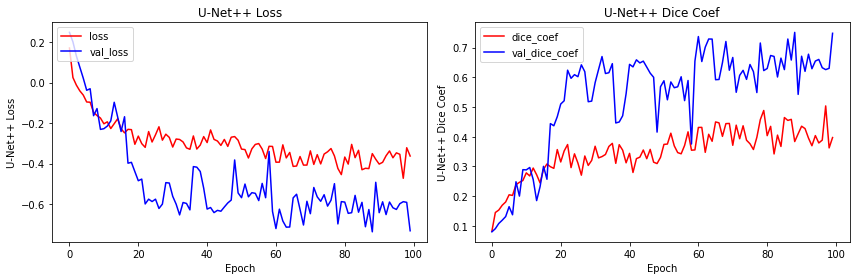

In [ ]:
draw_unet_history(unet_pp_history, model_name='U-Net++')

In [ ]:
# 모델 저장
UNET_PP_PATH = os.path.join(DATA_DIR, 'seg_model_unet++.h5')
unet_pp.save(UNET_PP_PATH)  # 학습한 모델을 저장해 주세요.

### 4. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석
  * 두 모델의 정량적, 정성적 성능을 비교: 시각화, IoU 계산 등
  * 세그멘테이션의 성능을 정량적으로 측정하기 위한 방법: IoU(Intersection over Union) 계산

In [ ]:
# IoU 계산함수
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    return iou_score

In [ ]:
# 모델 추론(inference) 결과 시각화 및 반환 함수

def get_output(model, preproc, image_path, output_path_dict, label_path, to_visualize=False):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  # 0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역

    output_detect = Image.fromarray(output)
    output_detect = output_detect.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output_detect.save(output_path_dict['detect'], 'png')  # 저장 # 도로 detection

    background = Image.fromarray(origin_img).convert('RGBA')
    output_blend = Image.blend(background, output_detect, alpha=0.5)
    output_blend.save(output_path_dict['blend'], 'png')  # 저장 # 도로 detection + 원본 이미지

    if to_visualize:
        # 시각화 및 저장
        plt.figure(figsize=(12,6))

        plt.subplot(211)
        plt.title('Detection')
        plt.axis('off')
        plt.imshow(output_detect)

        plt.subplot(212)
        plt.title('Blend')
        plt.axis('off')
        plt.imshow(output_blend)

        plt.tight_layout()
        plt.savefig(output_path_dict['all'])  # 이미지 2개 같이 저장
        plt.show()
    
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로(7)로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

#### U-Net 세그멘테이션 결과

In [ ]:
# 모델 불러오기
unet = tf.keras.models.load_model(UNET_PATH)

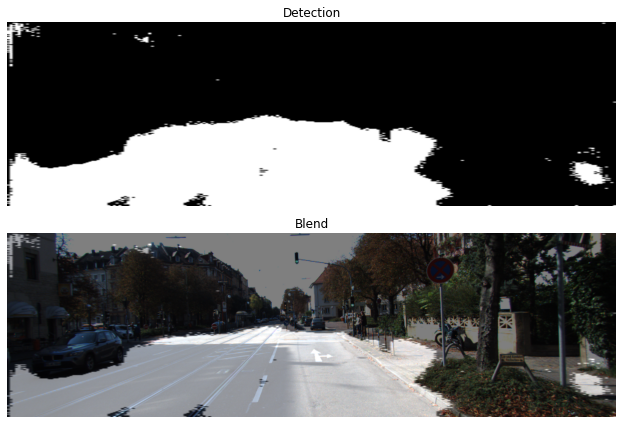

In [ ]:
# 모델 추론 결과 시각화

# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output_unet, prediction_unet, target_unet = get_output(
    unet, 
    test_preproc,
    image_path=TRAIN_PATH + f'/image_2/00{str(i).zfill(4)}_10.png',
    output_path_dict={
                      'detect': TRAIN_PATH + f'/unet_result_{str(i).zfill(3)}_detect.png',
                      'blend': TRAIN_PATH + f'/unet_result_{str(i).zfill(3)}_blend.png',
                      'all': TRAIN_PATH + f'/unet_result_{str(i).zfill(3)}_all.png',
                      },
    label_path=TRAIN_PATH + f'/semantic/00{str(i).zfill(4)}_10.png',
    to_visualize=True,
)

In [ ]:
# IoU 계산 결과
unet_iou = calculate_iou_score(target_unet, prediction_unet)
unet_iou

0.8405412946428571

#### U-Net++ 세그멘테이션 결과

In [ ]:
# 모델 불러오기
unet_pp = tf.keras.models.load_model(UNET_PP_PATH, compile=False)

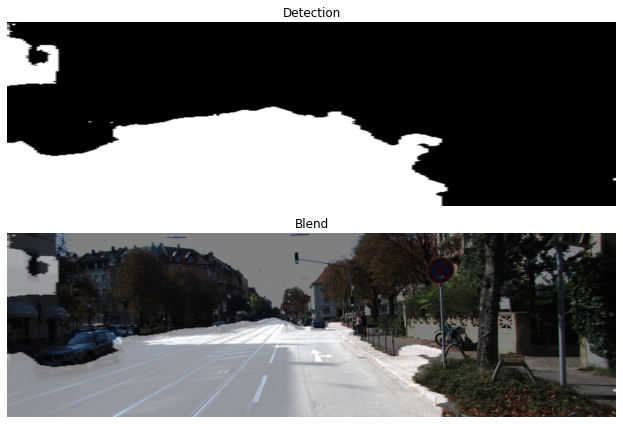

In [ ]:
# 모델 추론 결과 시각화

# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output_unet_pp, prediction_unet_pp, target_unet_pp = get_output(
    unet_pp, 
    test_preproc,
    image_path=TRAIN_PATH + f'/image_2/00{str(i).zfill(4)}_10.png',
    output_path_dict={
                      'detect': TRAIN_PATH + f'/unet++_result_{str(i).zfill(3)}_detect.png',
                      'blend': TRAIN_PATH + f'/unet++_result_{str(i).zfill(3)}_blend.png',
                      'all': TRAIN_PATH + f'/unet++_result_{str(i).zfill(3)}_all.png',
                      },
    label_path=TRAIN_PATH + f'/semantic/00{str(i).zfill(4)}_10.png',
    to_visualize=True,
)

In [ ]:
# IoU 계산 결과
unet_pp_iou = calculate_iou_score(target_unet_pp, prediction_unet_pp)
unet_pp_iou

0.809250031940718

#### 모든 테스트 이미지 결과 확인

In [ ]:
#추론 결과 저장 및 IoU 계산
def visualize_inference_and_get_iou(model, model_name='unet', to_visualize=False):
    iou = {}

    for i in range(len(os.listdir(os.path.join(TRAIN_PATH, 'image_2')))):
        output_unet, prediction_unet, target_unet = get_output(
            model, 
            test_preproc,
            image_path=TRAIN_PATH + f'/image_2/00{str(i).zfill(4)}_10.png',
            output_path_dict={
                              'detect': TRAIN_PATH + f'/{model_name}/{str(i).zfill(3)}_detect.png',
                              'blend': TRAIN_PATH + f'/{model_name}/{str(i).zfill(3)}_blend.png',
                              'all': TRAIN_PATH + f'/{model_name}/{str(i).zfill(3)}_all.png',
                              },
            label_path=TRAIN_PATH + f'/semantic/00{str(i).zfill(4)}_10.png',
            to_visualize=to_visualize,
        )

        iou[f'00{str(i).zfill(4)}_10.png'] = calculate_iou_score(target_unet, prediction_unet)

    return iou

In [ ]:
unet_iou_dict = visualize_inference_and_get_iou(model=unet, model_name='unet', to_visualize=False)

In [ ]:
unet_pp_iou_dict = visualize_inference_and_get_iou(model=unet_pp, model_name='unet_pp', to_visualize=False)

In [ ]:
iou_all = pd.DataFrame({'unet_iou': unet_iou_dict.values(), 'unet_pp_iou': unet_pp_iou_dict.values()}, index=unet_iou_dict.keys())
iou_all.describe()

unet_iou  unet_pp_iou
count  200.000000   200.000000
mean     0.727840     0.767607
std      0.180959     0.172977
min      0.000120     0.000000
25%      0.653759     0.680783
50%      0.788531     0.833963
75%      0.847080     0.885067
max      0.952240     0.962963

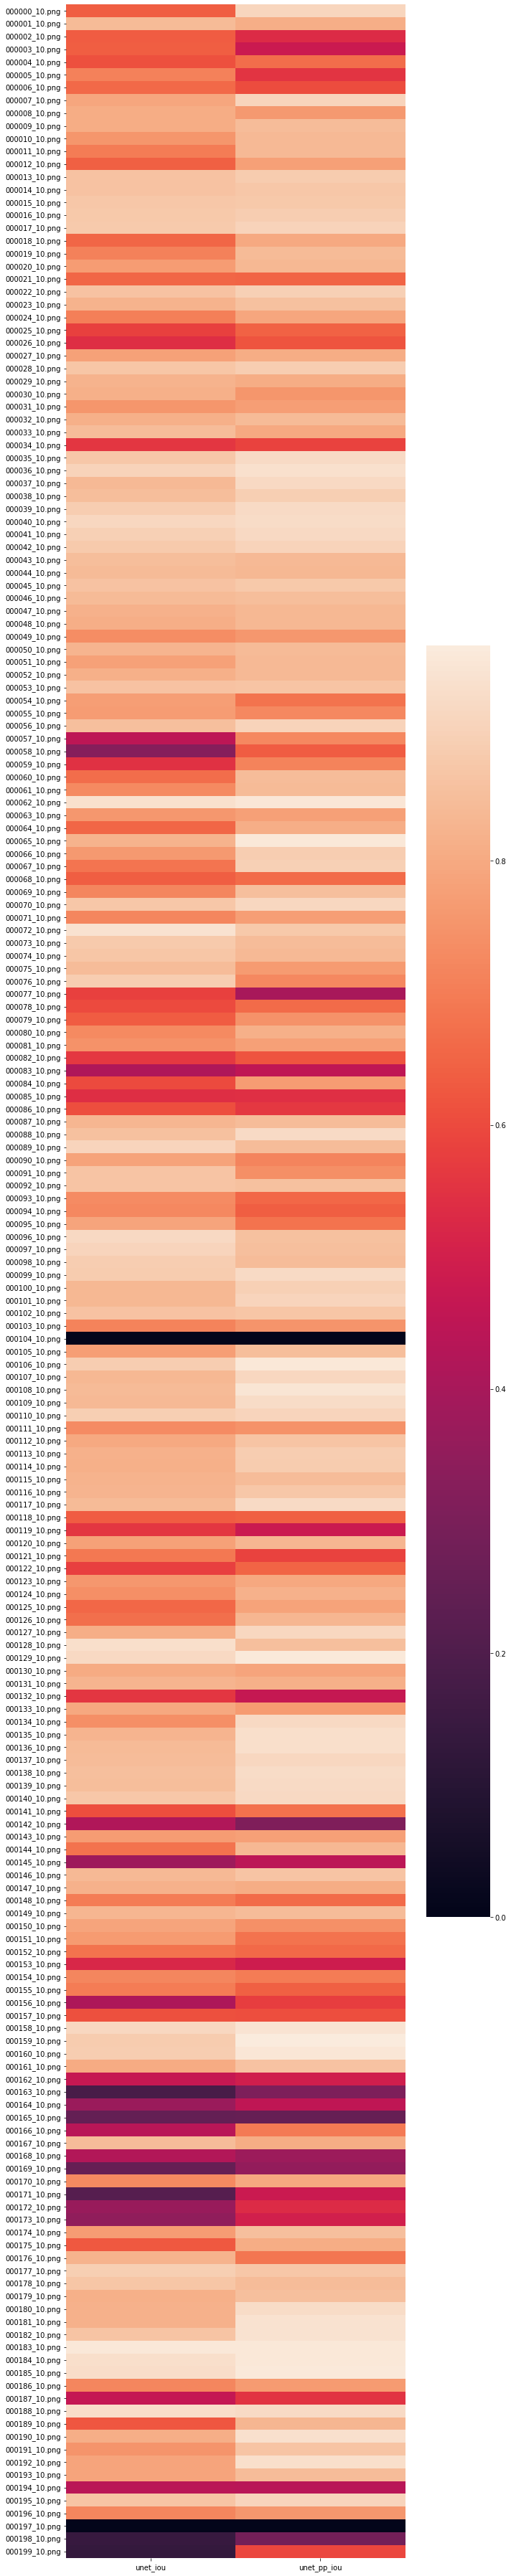

In [ ]:
# IoU 히트맵
import seaborn as sns

plt.figure(figsize=(10,50))
sns.heatmap(iou_all)
plt.tight_layout()
plt.show()

### 결론 및 회고
  * IoU 점수 기준으로 U-Net++ 모델이 U-Net 보다 성과가 좋음을 확인(평균 IoU값: U-Net++ 0.767607,  U-Net 0.727840)
  * IoU 히트맵상 U-Net++ 모델이 옅은 색이 많아 도로영역을 잘 찾아내고 있음
  * 노드에서 U-Net++ 모델을 만드는 과제를 주었는데, Deep Supervision 등 논문내용만 제시하고, 코드에 대한 힌트가 부족해 github등 기 작성 code를 참고해야 했음 --> activate 함수 등이 노드와 달라 노드의 relu함수로 수정하여 참조함
  * 코드를 따라 치고 실행해야 논문의 내용이 구체적으로 이해되는 것 같음(코드구현의 중요성)
  * model.summary로는 모델의 전체구조 파악이 어려웠는데 from tensorflow.keras.utils import plot_model API로 좀 더 자세한 구조를 알 수 있었음


< reference >
  * (paper) Rich feature hierarchies for accurate object detection and semantic segmentation Tech report
  * (paper) A Nested U-Net Architecture for Medical Image Segmentation(U-Net_v1)
  * (paper) Redesigning Skip Connections to Exploit Multiscale Features in Image Segmentation(U-Net_v2)
  * https://github.com/CarryHJR/Nested-UNet/blob/master/model.py
  * https://wsshin.tistory.com/2   